In [7]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [11]:
import numpy as np

# ---------- Data Loading Utilities ----------
def load_profits_from_file(filename, num_objectives, num_items):
    profits = np.zeros((num_objectives, num_items))
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            idx += 1  # skip weight
            profit = int(lines[idx])
            profits[obj, item] = profit
            idx += 1
    return profits

def load_weights_from_file(filename, num_objectives, num_items):
    weights = np.zeros((num_objectives, num_items), dtype=int)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            weight = int(lines[idx])
            weights[obj, item] = weight
            idx += 2  # skip profit
    return weights

def load_capacities_from_file(filename, num_objectives, num_items):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    capacities = []
    for obj in range(num_objectives):
        cap = float(lines[idx])
        capacities.append(cap)
        idx += 1 + 3 * num_items
    return np.array(capacities)

In [12]:
import numpy as np
from typing import Tuple, Dict, Any, Optional

class IntelligentAgent:
    """
    Adaptive MOACP agent with:
    - Multiple move heuristics (local, global, follow, mutation, diversity)
    - Adaptive move selection based on recent success/failure
    - Internal constraint checking before proposing moves
    - Receives archive context and updates best observation
    - Meta-adaptation API hook (MHRE)
    """

    def __init__(
        self,
        num_items: int,
        num_objectives: int,
        profits: Optional[np.ndarray] = None,
        weights: Optional[np.ndarray] = None,
        capacities: Optional[np.ndarray] = None,
        attempts_per_move: int = 50,
        smoothing: float = 0.1,
    ):
        self.num_items = num_items
        self.num_objectives = num_objectives
        self.profits = profits
        self.weights = weights
        self.capacities = capacities
        self.attempts_per_move = attempts_per_move
        self.smoothing = smoothing

        self.move_types = ["local_search", "global_search", "follow", "mutation", "diversity"]
        self.move_counts = {k: 1 for k in self.move_types}
        self.move_successes = {k: 1 for k in self.move_types}
        self.move_probs = np.array([0.25, 0.20, 0.15, 0.15, 0.25], dtype=np.float64)
        self.best_observation = None
        self.last_move_type = None

    def observe(self, state: Dict[str, Any]) -> np.ndarray:
        return np.array(state["Items"], dtype=np.int32)

    def act(self, observation: np.ndarray, context: Dict[str, Any] = None) -> Tuple[int, int]:
        archive_objs = None
        if context is not None and "archive_objs" in context:
            archive_objs = context["archive_objs"]

        move_idx = np.random.choice(len(self.move_types), p=self.move_probs)
        move_type = self.move_types[move_idx]
        self.last_move_type = move_type

        if move_type == "diversity" and archive_objs is not None and self.profits is not None:
            move = self.diversity_move(observation, archive_objs)
            if move is not None:
                return move

        for _ in range(self.attempts_per_move):
            if move_type == "local_search":
                move = self.local_search_move(observation)
            elif move_type == "global_search":
                move = self.global_search_move(observation)
            elif move_type == "follow":
                move = self.follow_move(observation)
            elif move_type == "mutation":
                move = self.mutation_move(observation)
            else:
                continue  # If "diversity" move failed, skip

            if self._is_feasible(observation, move):
                return move

        # Fallback to feasible random mutation
        for _ in range(self.attempts_per_move * 2):
            move = self.mutation_move(observation)
            if self._is_feasible(observation, move):
                return move

        return (0, 0)

    def report_move_result(self, move_type: Optional[str], success: bool):
        if move_type is None:
            move_type = self.last_move_type
        if move_type not in self.move_types:
            return
        self.move_counts[move_type] += 1
        if success:
            self.move_successes[move_type] += 1

        # Softmax update of move probabilities
        rates = np.array(
            [self.move_successes[k] / self.move_counts[k] for k in self.move_types],
            dtype=np.float64,
        )
        exp_rates = np.exp(rates / self.smoothing)
        new_probs = exp_rates / np.sum(exp_rates)
        self.move_probs = 0.5 * self.move_probs + 0.5 * new_probs
        self.move_probs = self.move_probs / np.sum(self.move_probs)

    def update_best(self, observation: np.ndarray):
        self.best_observation = observation.copy()

    def meta_adapt(self, meta_info: dict):
        # Optional hook for meta-level adaptation (e.g., MHRE architecture upgrades)
        pass

    # --- Heuristic Moves ---

    def local_search_move(self, observation):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or self.profits is None:
            return 0, 0
        profs_selected = np.sum(self.profits[:, items_selected], axis=0)
        profs_unselected = np.sum(self.profits[:, items_unselected], axis=0)
        remove_idx = items_selected[np.argmin(profs_selected)]
        add_idx = items_unselected[np.argmax(profs_unselected)]
        return int(remove_idx), int(add_idx)

    def global_search_move(self, observation):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or self.profits is None:
            return 0, 0
        profs_selected = np.sum(self.profits[:, items_selected], axis=0)
        profs_unselected = np.sum(self.profits[:, items_unselected], axis=0)
        ps = profs_selected + 1e-9
        pu = profs_unselected + 1e-9
        remove_idx = np.random.choice(items_selected, p=ps / np.sum(ps))
        add_idx = np.random.choice(items_unselected, p=pu / np.sum(pu))
        return int(remove_idx), int(add_idx)

    def follow_move(self, observation):
        if self.best_observation is None:
            return self.mutation_move(observation)
        diff = self.best_observation - observation
        add_candidates = np.where((diff == 1) & (observation == 0))[0]
        remove_candidates = np.where((diff == -1) & (observation == 1))[0]
        if len(add_candidates) == 0 or len(remove_candidates) == 0:
            return self.mutation_move(observation)
        add_idx = np.random.choice(add_candidates)
        remove_idx = np.random.choice(remove_candidates)
        return int(remove_idx), int(add_idx)

    def mutation_move(self, observation):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0:
            return 0, 0
        remove_idx = int(np.random.choice(items_selected))
        add_idx = int(np.random.choice(items_unselected))
        return remove_idx, add_idx

    def diversity_move(self, observation, archive_objs):
        best_move = None
        best_min_dist = -np.inf
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0:
            return None

        for _ in range(self.attempts_per_move):
            remove_idx = int(np.random.choice(items_selected))
            add_idx = int(np.random.choice(items_unselected))
            if not self._is_feasible(observation, (remove_idx, add_idx)):
                continue
            candidate = observation.copy()
            candidate[remove_idx] = 0
            candidate[add_idx] = 1
            candidate_objs = np.sum(self.profits * candidate, axis=1)
            dists = np.linalg.norm(archive_objs - candidate_objs, axis=1)
            min_dist = np.min(dists)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_move = (remove_idx, add_idx)
        return best_move

    # --- Feasibility Checking ---

    def _is_feasible(self, observation, move):
        if self.weights is None or self.capacities is None:
            return True
        remove_idx, add_idx = move
        if remove_idx == add_idx:
            return False
        items = observation.copy()
        if items[remove_idx] == 0 or items[add_idx] == 1:
            return False
        items[remove_idx] = 0
        items[add_idx] = 1
        total_weights = np.sum(self.weights * items, axis=1)
        feasible = np.all(total_weights <= self.capacities)
        return feasible

In [10]:
%%cython
from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp

import numpy as np
cimport numpy as np

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

cdef int NBITEMS = 250
cdef int ni = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000

cdef int nf = 2
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0
cdef int OBJ_Weights_lines = 0

# --- SMART AGENT GLOBAL ---
cdef public object py_agent = None

def set_agent(agent):
    """
    Register a Python-level agent object for smart search moves.
    """
    global py_agent
    py_agent = agent

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i, f
    with open(filename.decode(), "r") as source:
        _nf, _ni = [int(x) for x in source.readline().split()]
        nf = _nf
        ni = _ni
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            for i in range(ni):
                source.readline()
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

cdef np.ndarray get_archive_objs(pop *archive):
    cdef int i, j
    arr = np.zeros((archive.size, nf), dtype=np.float64)
    for i in range(archive.size):
        for j in range(nf):
            arr[i, j] = archive.ind_array[i].f[j]
    return arr

cdef np.ndarray get_items(ind *x):
    arr = np.zeros(ni, dtype=np.int32)
    for i in range(ni):
        arr[i] = x.Items[i]
    return arr

cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i, j, r, t, k, l, v, sol, mino, mp, maxp, consistant, pos, stop, convergence, ii, tmp_pris, tmp_nonpris, taille, feasible, tv, IM
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    while True:
        convergence = 0
        archive_objs = get_archive_objs(Sarchive) if Sarchive.size > 0 else None
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    # -------- SMART AGENT INTEGRATION --------
                    remove_idx = -1
                    add_idx = -1
                    agent_move_type = None
                    agent_success = False
                    if py_agent is not None:
                        state = {
                            "Items": [x.Items[ii] for ii in range(ni)],
                            "capa": [x.capa[ii] for ii in range(nf)],
                            "f": [x.f[ii] for ii in range(nf)],
                        }
                        context = {}
                        if archive_objs is not None:
                            context["archive_objs"] = archive_objs
                        try:
                            obs = py_agent.observe(state)
                            remove_idx, add_idx = py_agent.act(obs, context)
                        except Exception as e:
                            print("Agent error:", e)
                            remove_idx = -1
                            add_idx = -1
                    #print(f"Agent move: remove {remove_idx}, add {add_idx}")
                    # Fallback to random if agent does not provide usable indices
                    if remove_idx < 0 or remove_idx >= ni or x.Items[remove_idx] != 1:
                        while True:
                            mino = irand(ni)
                            if x.Items[mino] == 1:
                                break
                        remove_idx = mino
                    if add_idx < 0 or add_idx >= ni or x.Items[add_idx] != 0 or add_idx == remove_idx:
                        while True:
                            maxp = irand(ni)
                            if x.Items[maxp] == 0 and maxp != remove_idx:
                                break
                        add_idx = maxp

                    # Remove item
                    x.Items[remove_idx] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][remove_idx]
                        x.f[r] -= profits[r][remove_idx]

                    IM = 0
                    taille = 0
                    while IM < L:
                        item_to_add = add_idx
                        if item_to_add < 0 or item_to_add >= ni or x.Items[item_to_add] != 0 or item_to_add == remove_idx:
                            while True:
                                item_to_add = irand(ni)
                                if x.Items[item_to_add] == 0 and item_to_add != remove_idx:
                                    break
                        consistant = 1
                        r = 0
                        while r < nf and consistant == 1:
                            if x.capa[r] + weights[r][item_to_add] > capacities[r]:
                                consistant = 0
                            r += 1
                        if consistant == 1:
                            feasible = 1
                            r = 0
                            while r < taille and feasible:
                                if item_to_add == remplace[r]:
                                    feasible = 0
                                r += 1
                            if feasible == 1:
                                remplace[taille] = item_to_add
                                taille += 1
                                x.Items[item_to_add] = 1
                                x.nombr_nonpris -= 1
                                x.nombr += 1
                                for r in range(nf):
                                    x.capa[r] += weights[r][item_to_add]
                                    x.f[r] += profits[r][item_to_add]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    max_bound = calcMaxbound(SP, SP.size)
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    agent_success = (sol != -1)
                    if py_agent is not None:
                        try:
                            py_agent.report_move_result(None, agent_success)
                        except Exception:
                            pass
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x.Items[remove_idx] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][remove_idx]
                            x.f[r] += profits[r][remove_idx]
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    j += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break
    free(remplace)

def run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file):
    global nf, ni, NBITEMS, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights

    alpha = 10
    paretoIni = 28000

    NBL = 100
    NRUNS = 10

    for run in range(1, NRUNS+1):
        NBITEMS = nbitems
        ni = nbitems
        nf = num_objectives

        print(f"RUN {run}/{NRUNS} -- {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")

        nombreLIGNE = 0
        nextLn = 0
        inv = 0

        seed(run)
        loadMOKP(instance_file)
        read_weights_file(weights_file)

        vector_weight = <double *>chk_malloc(nf * sizeof(double))
        P = create_pop(paretoIni, nf)

        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)
            Indicator_local_search1(solutions, archive, alpha)
            extractPtoArchive(archive, P)
            # Update agent with best observation (MHRE-style best-following)
            if py_agent is not None and P.size > 0:
                best_idx = 0
                best_val = P.ind_array[0].fitness
                for i in range(1, P.size):
                    if P.ind_array[i].fitness > best_val:
                        best_idx = i
                        best_val = P.ind_array[i].fitness
                best_items = get_items(P.ind_array[best_idx])
                try:
                    py_agent.update_best(best_items)
                except Exception:
                    pass
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)

        with open(output_file, "a") as fpareto:
            fpareto.write("\n")
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")

        complete_free_pop(P)
        cleanup_globals()

In [6]:
# Set your parameters and file names
nbitems = 250
num_objectives = 2
instance_file = b"250.2.txt"
weights_file = b"Weights_2obj_FQ200.txt"
output_file = "pipp.txt"

# Load data for agent
profits = load_profits_from_file("250.2.txt", num_objectives, nbitems)
weights = load_weights_from_file("250.2.txt", num_objectives, nbitems)
capacities = load_capacities_from_file("250.2.txt", num_objectives, nbitems)

# Create agent with all info
agent = IntelligentAgent(nbitems, num_objectives, profits=profits, weights=weights, capacities=capacities)

# Register agent with Cython core
set_agent(agent)

# Run the optimizer
run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file)
print("Optimization completed.")

RUN 1/10 -- 250.2.txt nbitems=250 nf=2 => pipp.txt
RUN 2/10 -- 250.2.txt nbitems=250 nf=2 => pipp.txt
RUN 3/10 -- 250.2.txt nbitems=250 nf=2 => pipp.txt
RUN 4/10 -- 250.2.txt nbitems=250 nf=2 => pipp.txt
RUN 5/10 -- 250.2.txt nbitems=250 nf=2 => pipp.txt
RUN 6/10 -- 250.2.txt nbitems=250 nf=2 => pipp.txt
RUN 7/10 -- 250.2.txt nbitems=250 nf=2 => pipp.txt
RUN 8/10 -- 250.2.txt nbitems=250 nf=2 => pipp.txt
RUN 9/10 -- 250.2.txt nbitems=250 nf=2 => pipp.txt
RUN 10/10 -- 250.2.txt nbitems=250 nf=2 => pipp.txt
Optimization completed.


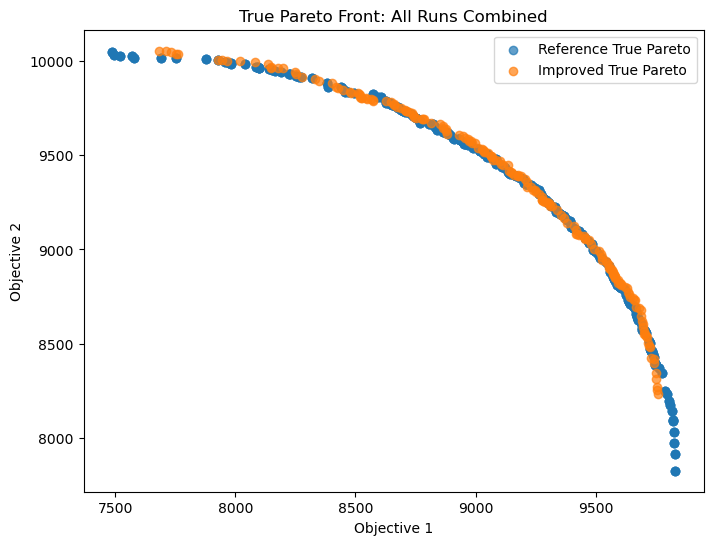

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("pipp.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

In [8]:
# Set your parameters and file names
nbitems = 250
num_objectives = 2
instance_file = b"250.2.txt"
weights_file = b"Weights_2obj_FQ200.txt"
output_file = "output.txt"

# Load data for agent
profits = load_profits_from_file("250.2.txt", num_objectives, nbitems)
weights = load_weights_from_file("250.2.txt", num_objectives, nbitems)
capacities = load_capacities_from_file("250.2.txt", num_objectives, nbitems)

# Create agent with all info
agent = IntelligentAgent(nbitems, num_objectives, profits=profits, weights=weights, capacities=capacities)

# Register agent with Cython core
set_agent(agent)

# Run the optimizer
run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file)
print("Optimization completed.")

RUN 1/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 2/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 3/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 4/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 5/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 6/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 7/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 8/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 9/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 10/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
Optimization completed.


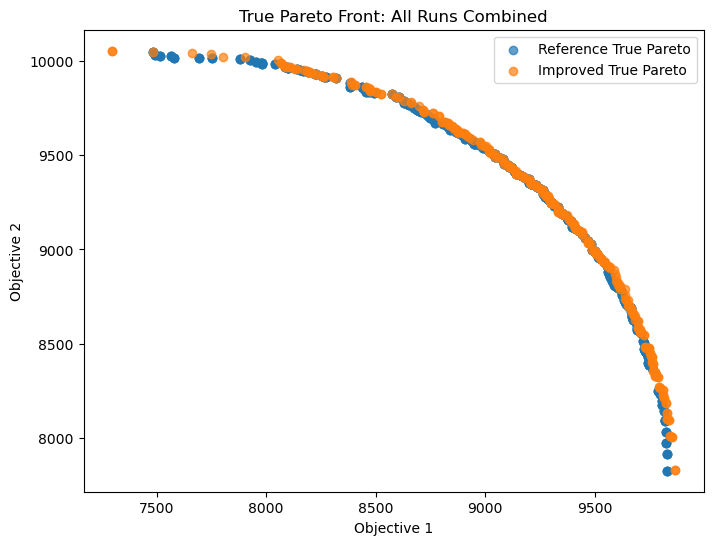

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("output.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

In [1]:
!conda install -c conda-forge pymoo

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.



The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda==2022.10=py39_0
  - defaults/win-64::anaconda-client==1.11.0=py39haa95532_0
  - defaults/win-64::anaconda-navigator==2.3.1=py39haa95532_0
  - defaults/win-64::anaconda-project==0.11.1=py39haa95532_0
  - defaults/win-64::argon2-cffi-bindings==21.2.0=py39h2bbff1b_0
  - defaults/win-64::astropy==5.1=py39h080aedc_0
  - defaults/noarch::automat==20.2.0=py_0
  - defaults/noarch::backports.functools_lru_cache==1.6.4=pyhd3eb1b0_0
  - defaults/win-64::bcrypt==3.2.0=py39h2bbff1b_1
  - defaults/win-64::bkcharts==0.2=py39haa95532_1
  - defaults/win-64::bokeh==2.4.3=py39haa95532_0
  - defaults/win-64::boto3==1.24.28=py39haa95532_0
  - defaults/win-64::botocore==1.27.28=py39haa95532_0
  - defaults/win-64::bottleneck==1.3.5=py39h080aedc_0
  - defaults/win-64::brotlipy==0.7.0=py39h2bbff1b_1003
  - defaults/win-64::clyent==1.2.2=py39haa95532_1
  

In [29]:
import numpy as np
from pymoo.indicators.hv import HV

# Use your previously calculated Pareto fronts
ref = ref_pareto
new = new_pareto

# Calculate the reference point (must be worse than any point in both sets)
ref_point = np.max(np.vstack([ref, new]), axis=0) + 1

# Instantiate HV indicator
hv = HV(ref_point=ref_point)

# Compute and print hypervolumes
print("Reference HV:", hv(ref))
print("Improved HV:", hv(new))

Reference HV: 1199470.0
Improved HV: 1159322.0


In [ ]:
import numpy as np

# --- IntelligentAgent as before, but with LLM-aware meta_adapt ---

class IntelligentAgent:
    def __init__(
        self,
        num_items,
        num_objectives,
        profits=None,
        weights=None,
        capacities=None,
        attempts_per_move=50,
        smoothing=0.1,
    ):
        self.num_items = num_items
        self.num_objectives = num_objectives
        self.profits = profits
        self.weights = weights
        self.capacities = capacities
        self.attempts_per_move = attempts_per_move
        self.smoothing = smoothing
        self.move_types = ["local_search", "global_search", "follow", "mutation", "diversity"]
        self.move_counts = {k: 1 for k in self.move_types}
        self.move_successes = {k: 1 for k in self.move_types}
        self.move_probs = np.array([0.25, 0.20, 0.15, 0.15, 0.25], dtype=np.float64)
        self.best_observation = None
        self.last_move_type = None

    def act(self, observation, context=None):
        archive_objs = None
        if context is not None and "archive_objs" in context:
            archive_objs = context["archive_objs"]

        move_idx = np.random.choice(len(self.move_types), p=self.move_probs)
        move_type = self.move_types[move_idx]
        self.last_move_type = move_type

        if move_type == "diversity" and archive_objs is not None and self.profits is not None:
            move = self.diversity_move(observation, archive_objs)
            if move is not None:
                return move

        for _ in range(self.attempts_per_move):
            if move_type == "local_search":
                move = self.local_search_move(observation)
            elif move_type == "global_search":
                move = self.global_search_move(observation)
            elif move_type == "follow":
                move = self.follow_move(observation)
            elif move_type == "mutation":
                move = self.mutation_move(observation)
            else:
                continue

            if self._is_feasible(observation, move):
                return move

        for _ in range(self.attempts_per_move * 2):
            move = self.mutation_move(observation)
            if self._is_feasible(observation, move):
                return move

        return (0, 0)

    def report_move_result(self, move_type, success):
        if move_type is None:
            move_type = self.last_move_type
        if move_type not in self.move_types:
            return
        self.move_counts[move_type] += 1
        if success:
            self.move_successes[move_type] += 1
        rates = np.array(
            [self.move_successes[k] / self.move_counts[k] for k in self.move_types],
            dtype=np.float64,
        )
        exp_rates = np.exp(rates / self.smoothing)
        new_probs = exp_rates / np.sum(exp_rates)
        self.move_probs = 0.5 * self.move_probs + 0.5 * new_probs
        self.move_probs = self.move_probs / np.sum(self.move_probs)

    def update_best(self, observation):
        self.best_observation = observation.copy()

    def meta_adapt(self, meta_info):
        # This method can be called by the LLM agent to adjust strategies
        if "move_probs" in meta_info:
            self.move_probs = np.array(meta_info["move_probs"])
            self.move_probs = self.move_probs / np.sum(self.move_probs)
        if "new_move_types" in meta_info:
            for m in meta_info["new_move_types"]:
                if m not in self.move_types:
                    self.move_types.append(m)
        # Example: LLM could inject new moves here

    def local_search_move(self, observation):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or self.profits is None:
            return 0, 0
        profs_selected = np.sum(self.profits[:, items_selected], axis=0)
        profs_unselected = np.sum(self.profits[:, items_unselected], axis=0)
        remove_idx = items_selected[np.argmin(profs_selected)]
        add_idx = items_unselected[np.argmax(profs_unselected)]
        return int(remove_idx), int(add_idx)

    def global_search_move(self, observation):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or self.profits is None:
            return 0, 0
        profs_selected = np.sum(self.profits[:, items_selected], axis=0)
        profs_unselected = np.sum(self.profits[:, items_unselected], axis=0)
        ps = profs_selected + 1e-9
        pu = profs_unselected + 1e-9
        remove_idx = np.random.choice(items_selected, p=ps / np.sum(ps))
        add_idx = np.random.choice(items_unselected, p=pu / np.sum(pu))
        return int(remove_idx), int(add_idx)

    def follow_move(self, observation):
        if self.best_observation is None:
            return self.mutation_move(observation)
        diff = self.best_observation - observation
        add_candidates = np.where((diff == 1) & (observation == 0))[0]
        remove_candidates = np.where((diff == -1) & (observation == 1))[0]
        if len(add_candidates) == 0 or len(remove_candidates) == 0:
            return self.mutation_move(observation)
        add_idx = np.random.choice(add_candidates)
        remove_idx = np.random.choice(remove_candidates)
        return int(remove_idx), int(add_idx)

    def mutation_move(self, observation):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0:
            return 0, 0
        remove_idx = int(np.random.choice(items_selected))
        add_idx = int(np.random.choice(items_unselected))
        return remove_idx, add_idx

    def diversity_move(self, observation, archive_objs):
        best_move = None
        best_min_dist = -np.inf
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0:
            return None
        for _ in range(self.attempts_per_move):
            remove_idx = int(np.random.choice(items_selected))
            add_idx = int(np.random.choice(items_unselected))
            if not self._is_feasible(observation, (remove_idx, add_idx)):
                continue
            candidate = observation.copy()
            candidate[remove_idx] = 0
            candidate[add_idx] = 1
            candidate_objs = np.sum(self.profits * candidate, axis=1)
            dists = np.linalg.norm(archive_objs - candidate_objs, axis=1)
            min_dist = np.min(dists)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_move = (remove_idx, add_idx)
        return best_move

    def _is_feasible(self, observation, move):
        if self.weights is None or self.capacities is None:
            return True
        remove_idx, add_idx = move
        if remove_idx == add_idx:
            return False
        items = observation.copy()
        if items[remove_idx] == 0 or items[add_idx] == 1:
            return False
        items[remove_idx] = 0
        items[add_idx] = 1
        total_weights = np.sum(self.weights * items, axis=1)
        feasible = np.all(total_weights <= self.capacities)
        return feasible

# --- Simulated LLM Reflection Function ---
def simulated_llm_reflection(agent_stats):
    """
    Simulates an LLM's role in MHRE: Given agent stats, return new move probabilities
    or suggest new moves or architecture strategies.
    """
    # Example logic: If diversity is low, boost mutation and diversity
    if agent_stats['archive_diversity'] < 1.5:
        # LLM suggests: Increase mutation and diversity moves
        suggestion = {
            'move_probs': [0.15, 0.10, 0.10, 0.40, 0.25],  # More mutation!
        }
    else:
        # LLM suggests: Focus more on local/global
        suggestion = {
            'move_probs': [0.30, 0.25, 0.10, 0.15, 0.20],
        }
    return suggestion

def measure_archive_diversity(archive_objs):
    """Simple diversity metric: average Euclidean distance between archive solutions."""
    if len(archive_objs) < 2:
        return 0.0
    arr = np.array(archive_objs)
    dists = []
    for i in range(len(arr)):
        for j in range(i+1, len(arr)):
            dists.append(np.linalg.norm(arr[i]-arr[j]))
    return np.mean(dists)

# --- Main Optimization Loop with LLM Reflection ---
def main():
    np.random.seed(42)
    num_items = 10
    num_objectives = 2
    profits = np.random.randint(1, 10, size=(num_objectives, num_items))
    weights = np.random.randint(1, 5, size=(num_objectives, num_items))
    capacities = np.array([15, 12])
    agent = IntelligentAgent(
        num_items=num_items,
        num_objectives=num_objectives,
        profits=profits,
        weights=weights,
        capacities=capacities,
        attempts_per_move=20,
        smoothing=0.15
    )
    population = [np.random.randint(0, 2, size=num_items) for _ in range(8)]
    archive = []
    archive_objs = []

    for generation in range(50):
        for obs in population:
            context = {"archive_objs": np.array([np.sum(profits * p, axis=1) for p in archive]) if archive else None}
            move = agent.act(obs, context)
            candidate = obs.copy()
            remove_idx, add_idx = move
            if candidate[remove_idx] == 1 and candidate[add_idx] == 0:
                candidate[remove_idx] = 0
                candidate[add_idx] = 1
            candidate_obj = np.sum(profits * candidate, axis=1)
            total_weights = np.sum(weights * candidate, axis=1)
            feasible = np.all(total_weights <= capacities)
            success = False
            if feasible:
                # Pareto check (simple, not full dominance logic)
                dominated = False
                for other_obj in archive_objs:
                    if np.all(other_obj >= candidate_obj) and np.any(other_obj > candidate_obj):
                        dominated = True
                        break
                if not dominated:
                    archive.append(candidate.copy())
                    archive_objs.append(candidate_obj)
                    agent.update_best(candidate)
                    success = True
            agent.report_move_result(agent.last_move_type, success)

        # MHRE/LLM Reflection Step every 10 generations
        if generation > 0 and generation % 10 == 0:
            agent_stats = {
                'move_counts': agent.move_counts,
                'move_successes': agent.move_successes,
                'move_probs': agent.move_probs,
                'archive_diversity': measure_archive_diversity(archive_objs),
            }
            # Call simulated LLM
            suggestion = simulated_llm_reflection(agent_stats)
            agent.meta_adapt(suggestion)
            print(f"Generation {generation}: LLM reflection updated move_probs to {agent.move_probs}")

    # Print final archive
    print("Final Pareto Archive (objectives):")
    print(np.array(archive_objs))

if __name__ == "__main__":
    main()

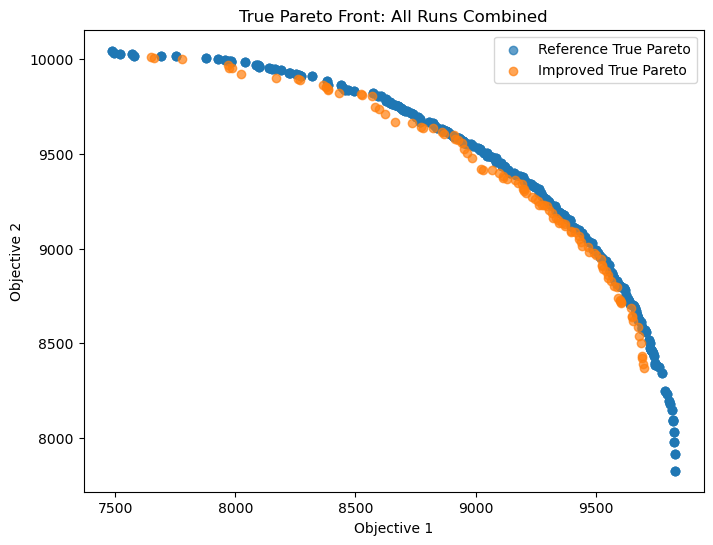

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("bro2.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()